In [ ]:
#Getting drug data from ChEMBL database
#This script connects to the ChEMBL database and retrieves information about drugs and their interactions with a specified protein target.

import importlib
import chembl_connect as cc
importlib.reload(cc)
import pandas as pd
import json 

df = pd.read_csv("drug.csv")
drug_names = df["Drug"].dropna().unique().tolist()
target_names = ["Dopamine transporter"]

for protein in target_names:
    interaction = cc.main(drug_list= drug_names, protein_name= protein)

# Save all records to a CSV file
df = pd.DataFrame(interaction)
output_file = "drug_target_interactions.csv"
df.to_csv(output_file, index=False)
print(f"\nAll interactions saved to {output_file}.")

Searching for ChEMBL ID for target: 'Dopamine transporter'...
{'q': 'Dopamine transporter', 'limit': 1, 'format': 'json', 'organism': 'Homo sapiens'}
b'{"page_meta": {"limit": 1, "next": "/chembl/api/data/target/search.json?limit=1&offset=1&q=Dopamine+transporter&organism=Homo+sapiens", "offset": 0, "previous": null, "total_count": 236}, "targets": [{"cross_references": [], "organism": "Homo sapiens", "pref_name": "Dopamine transporter", "score": 19.0, "species_group_flag": false, "target_chembl_id": "CHEMBL238", "target_components": [{"accession": "Q01959", "component_description": "Sodium-dependent dopamine transporter", "component_id": 346, "component_type": "PROTEIN", "relationship": "SINGLE PROTEIN", "target_component_synonyms": [{"component_synonym": "DAT", "syn_type": "UNIPROT"}, {"component_synonym": "DAT1", "syn_type": "GENE_SYMBOL_OTHER"}, {"component_synonym": "DA transporter", "syn_type": "UNIPROT"}, {"component_synonym": "SLC6A3", "syn_type": "GENE_SYMBOL"}, {"component_sy

KeyboardInterrupt: 

In [ ]:
##Building Similarity Matrix
#This script calculates the pairwise Tanimoto similarity between drugs based on their Morgan fingerprints.
import similarity as sim
importlib.reload(sim)


drugs_df = pd.read_csv("drug_target_interactions.csv")

#create a new dataframe to store the drug names and their corresponding SMILES strings
drug_smiles= drugs_df[['drug_name', 'canonical_smiles']].dropna().drop_duplicates()

#generate Morgan fingerprints for each drug using the canonical SMILES strings
drug_smiles['fingerprint'] = drug_smiles['canonical_smiles'].apply(sim.get_morgan_fingerprint)
print(drug_smiles.head())

# calculates the Tanimoto similarity between the fingerprints of each drug and a reference drug 
results = []

for i in range(len(drug_smiles)): #select each drug one by one 
    drug1 = drug_smiles.iloc[i] #get the current drug row
    for j in range(len(drug_smiles)): #for each drug, loop through all drugs again to compare
        if i == j:
            continue # skip if it's the same drug
        drug2 = drug_smiles.iloc[j] #get the next drug row
        fp1 = drug1["fingerprint"] 
        fp2 = drug2["fingerprint"] 
        
        sim_score = sim.calculate_tanimoto_similarity(fp1, fp2) # calculate the similarity score between the two fingerprints
        results.append({
            'drug_1': drug1['drug_name'],
            'drug_2': drug2['drug_name'],
            'similarity': sim_score
        })

similarity_df = pd.DataFrame(results)
similarity_df.to_csv("pairwise_drug_similarity.csv", index=False)

#Find the 'k' most similar drugs
similarities = pd.read_csv("pairwise_drug_similarity.csv")
most_similar = similarities.sort_values(by='similarity', ascending=False)[:k] # Replace 'k' with the desired number of top similar drugs



                       drug_name                      canonical_smiles  \
0                Methylphenidate            COC(=O)C(c1ccccc1)C1CCCCN1   
4  Methylphenidate Hydrochloride         COC(=O)C(c1ccccc1)C1CCCCN1.Cl   
6                    Amphetamine                        CC(N)Cc1ccccc1   
7                    Atomoxetine                        CC(N)Cc1ccccc1   
8                      Modafinil  NC(=O)C[S+]([O-])C(c1ccccc1)c1ccccc1   

                                         fingerprint  
0  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
6  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
8  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  


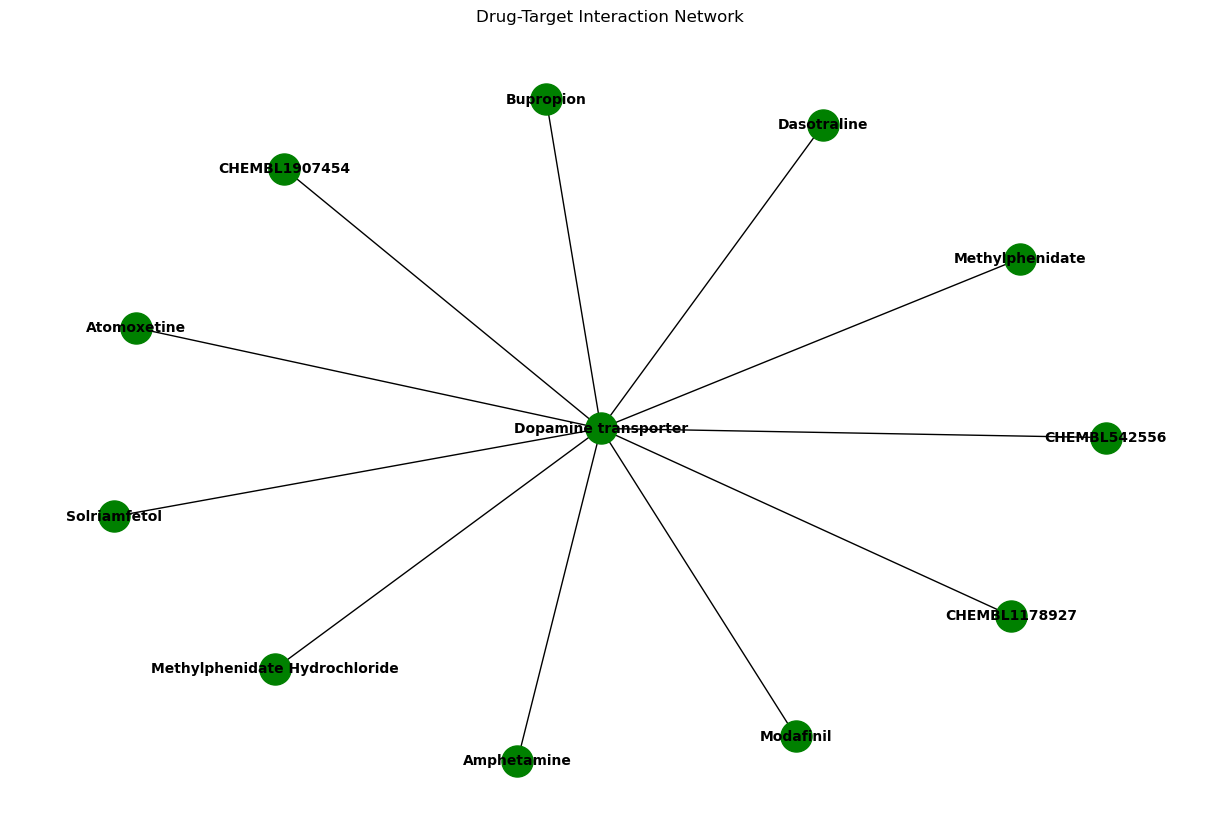

In [52]:
##Building DTI Network 
#This script builds a drug-target interaction (DTI) network from the drug-target interactions data.

import networkx as nx
import matplotlib.pyplot as plt

interactions = drugs_df[['drug_name', 'target_name']].dropna()
interaction_pairs = list(interactions.itertuples(index=False, name=None))

drugs = drug_smiles['drug_name'].unique().tolist()
targets = drugs_df['target_name'].dropna().unique().tolist()

G = sim.build_dti_network(interaction_pairs, drugs, targets)

# Draw the graph (source: https://networkx.org/documentation/stable/reference/drawing.html)
plt.figure(figsize=(12, 8))
nx.draw_spring(G, with_labels=True, node_size=500, node_color="green", font_size=10, font_weight="bold")
plt.title("Drug-Target Interaction Network")
plt.show()

In [96]:
##Training for DTI prediction model
#This script prepares the data for training a drug-target interaction prediction model by combining drug-target interactions
import pandas as pd

#Define most similar drugs in the similarity_df by sorting by similarity score
most_similar = similarity_df.sort_values(by='similarity', ascending=False)

#Check if the interest drugs are in the interactions dataframe
# Filter only rows where standard_type is Ki (case-insensitive)
ki_df = df[df['standard_type'].str.lower() == 'ki'].copy()
#print(ki_df.head())
#concert standard_value to numeric
ki_df['standard_value'] = pd.to_numeric(ki_df['standard_value'])

"""
Creating a loop where we predict the interactions based on 
    #1.  Similarity score: 
    if sim score > threshold = 0.5 then we continue predicting the interaction
    #2.  Drug-target interactions:
    if drug has interaction with target (Ki value > 0) 
    When both of these conditions are met, we can predict the interaction, return 1 as binding, else return 0 as non-binding.
"""

# Initialize binding column to 0 
ki_df['binding'] = 0
# Set threshold
threshold = 0.5

# # Iterate through each row in ki_df to predict interaction
# for i, row in most_similar.iterrows():
#     ref_drug= row['drug_1'] #referercene drug
#     com_drug = row['drug_2'] #compare drug
#     similarity = row['similarity']
    
#     #  condition 1. if similarity score is above the threshold
#     if similarity >= threshold:
#         #condition 2. if drug1 has interaction with target baseed on Ki value >0
        
#         binding_ki = ki_df[
#             (ki_df['drug_name'] == com_drug)  &
#             (ki_df['standard_value'] > 0)
#         ]
        
#         if not binding_ki.empty:
#             # Set binding = 1 only for matched rows
#             ki_df.loc[ki_df['drug_name'] == com_drug,'binding'
#             ] = 1
            

# #sort the ki_df ki values in ascending order
# ki_df = ki_df.sort_values(by='standard_value', ascending=False)         
ki_df # Display the first 10 rows of the updated DataFrame




,drug_name,drug_chembl_id,target_name,target_chembl_id,canonical_smiles,standard_type,standard_value,standard_units,pchembl_value,document_doi,source_url,binding
1,Methylphenidate,CHEMBL796,Dopamine transporter,CHEMBL238,COC(=O)C(c1ccccc1)C1CCCCN1,Ki,110.0,nM,6.96,None,https://www.ebi.ac.uk/chembl/g/#search_results...,0
3,Methylphenidate,CHEMBL796,Dopamine transporter,CHEMBL238,COC(=O)C(c1ccccc1)C1CCCCN1,Ki,34.0,nM,7.47,None,https://www.ebi.ac.uk/chembl/g/#search_results...,0
9,Modafinil,CHEMBL1373,Dopamine transporter,CHEMBL238,NC(=O)C[S+]([O-])C(c1ccccc1)c1ccccc1,Ki,1456.0,nM,5.84,None,https://www.ebi.ac.uk/chembl/g/#search_results...,0
10,Modafinil,CHEMBL1373,Dopamine transporter,CHEMBL238,NC(=O)C[S+]([O-])C(c1ccccc1)c1ccccc1,Ki,3090.0,nM,5.51,None,https://www.ebi.ac.uk/chembl/g/#search_results...,0
11,Modafinil,CHEMBL1373,Dopamine transporter,CHEMBL238,NC(=O)C[S+]([O-])C(c1ccccc1)c1ccccc1,Ki,13000.0,nM,4.89,None,https://www.ebi.ac.uk/chembl/g/#search_results...,0
12,Modafinil,CHEMBL1373,Dopamine transporter,CHEMBL238,NC(=O)C[S+]([O-])C(c1ccccc1)c1ccccc1,Ki,2000.0,nM,5.70,None,https://www.ebi.ac.uk/chembl/g/#search_results...,0
13,Modafinil,CHEMBL1373,Dopamine transporter,CHEMBL238,NC(=O)C[S+]([O-])C(c1ccccc1)c1ccccc1,Ki,927.0,nM,6.03,None,https://www.ebi.ac.uk/chembl/g/#search_results...,0
